# Installation of libraries & imports

In [ ]:
!pip install nibabel
!pip PIL
!pip install numpy

ERROR: unknown command "PIL"


In [ ]:
import nibabel as nb
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
from tqdm import tqdm
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import cv2
from skimage.transform import resize

# Data source

1. you can get the dataset by requesting via the following download tab in the followinf site https://www.ub.edu/mnms-2/

2. Upload the raw data you to to your goodle drive and update the followig path variables

In [ ]:
raw_data_path = "your data directory (.rar file)"
target_data_path = "your prefered directory to store the processed data"

# Connect to the google drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Publications and Researches/Multi-Disease, Multi-View & Multi-Center Right Ventricular Segmentation in Cardiac MRI/updated data'

/content/drive/MyDrive/Publications and Researches/Multi-Disease, Multi-View & Multi-Center Right Ventricular Segmentation in Cardiac MRI/updated data


In [ ]:
# unrar the raw data
!unrar x -v '{raw_data_path}'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal

Cannot open your data directory (.rar file)
No such file or directory
No files to extract


# Partition the data

In [ ]:
import shutil
import os

source_dir = target_data_path + "/MnM2/dataset"
training_dest = target_data_path + "/MnM2/training"
validation_dest = target_data_path + "/MnM2/validation"
testing_dest = target_data_path + "/MnM2/testing"

os.makedirs(training_dest, exist_ok=True)
os.makedirs(validation_dest, exist_ok=True)
os.makedirs(testing_dest, exist_ok=True)

folder_names = [str(i).zfill(3) for i in range(1, 361)]

# Split the folder names into training, validation, and testing sets as per the TABLE II Number of Studies Per Pathology in Each Dataset Partition in https://ieeexplore.ieee.org/document/10103611
training_folders = folder_names[:160]
validation_folders = folder_names[160:200]
testing_folders = folder_names[200:]

for folder in training_folders:
    shutil.copytree(os.path.join(source_dir, folder), os.path.join(training_dest, folder))

for folder in validation_folders:
    shutil.copytree(os.path.join(source_dir, folder), os.path.join(validation_dest, folder))

for folder in testing_folders:
    shutil.copytree(os.path.join(source_dir, folder), os.path.join(testing_dest, folder))

print("Folders copied successfully!")


NameError: ignored

# Visualize raw data

In [ ]:
def plot_images(img, mask):
  print("img " , img.shape)
  print("mask ", mask.shape)
  print("mask min ", mask.min())
  print("mask max ", mask.max())
  print("mask unique values ", np.unique(mask))

  viz_dict = {"Image": img[:,:,0], "Segmentation Map": mask[:,:]}

  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.title(i)
    plt.axis("on")
    count += 1

def plot_images_by_path(dir, train_or_test, la_or_sa, ed_or_es, id):
  img = nb.load(dir+train_or_test+"/"+id+"/"+id+"_"+la_or_sa+"_"+ed_or_es+".nii.gz").get_fdata()
  mask = nb.load(dir+train_or_test+"/"+id+"/"+id+"_"+la_or_sa+"_"+ed_or_es+"_gt.nii.gz").get_fdata()

  plot_images(img, mask)

#plot 3d from the image
def plot_3d_images(img, mask):
  num_slices = img.shape[2]

  print("img " , img.shape)
  print("mask ", mask.shape)
  print("mask min ", mask.min())
  print("mask max ", mask.max())
  print("mask unique values ", np.unique(mask))

  fig, axes = plt.subplots(num_slices, 2, figsize=(10, num_slices * 5))

  for i in range(num_slices):
      axes[i, 0].imshow(img[:, :, i], cmap='gray')
      axes[i, 0].set_title("Slice {}".format(i))
      axes[i, 0].axis('off')

      axes[i, 1].imshow(img[:, :, i], cmap='gray')
      axes[i, 1].imshow(mask[:, :, i], alpha=0.5, cmap='jet')
      axes[i, 1].set_title("Segmentation Slice {}".format(i))
      axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()

#plot 3d images from the file path
def plot_3d_images_by_path(dir, train_or_test, la_or_sa, ed_or_es, id):
  img = nb.load(dir + train_or_test + "/" + id + "/" + id + "_" + la_or_sa + "_" + ed_or_es + ".nii.gz").get_fdata()
  mask = nb.load(dir + train_or_test + "/" + id + "/" + id + "_" + la_or_sa + "_" + ed_or_es + "_gt.nii.gz").get_fdata()

  plot_3d_images(img, mask)

def plot_images_after_cleaning(img,mask):
  print(img.shape,mask.shape,mask.min(),mask.max(), np.unique(mask))
  viz_dict = {"Image": img[:,:,0], "Segmentation Map": mask}
  fig = plt.figure(figsize=(15, 15))

  count = 2

  for i, j in viz_dict.items():
    ax = plt.subplot(1, 3, count)
    plt.imshow(j)
    plt.colorbar()
    plt.title(i)
    plt.axis("on")
    count += 1

## SA samples (3d)

img  (256, 256, 12)
mask  (256, 256, 12)
mask min  0.0
mask max  3.0
mask unique values  [0. 1. 2. 3.]


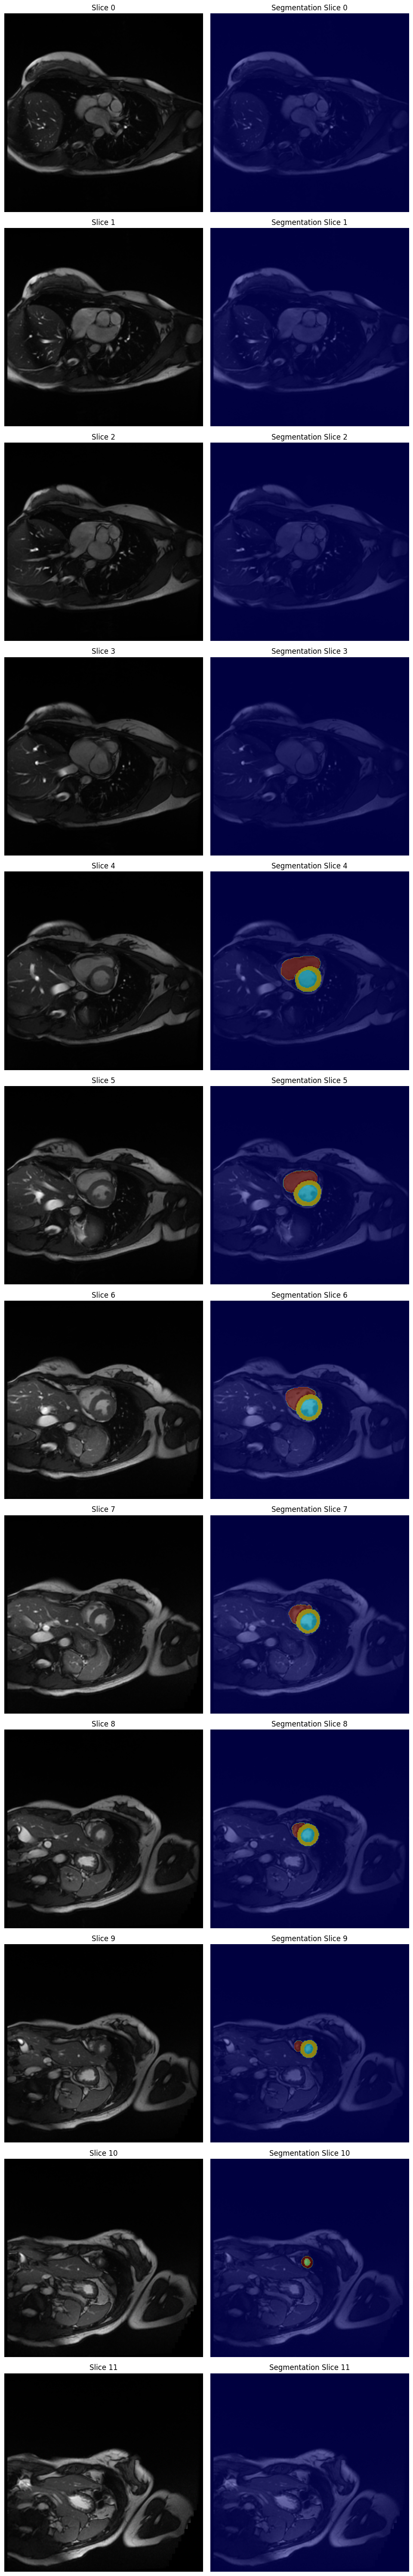

In [ ]:
plot_3d_images_by_path('MnM2/','training','SA','ES','001')

## LA Samples

img  (256, 256, 1)
mask  (256, 256, 1)
mask min  0.0
mask max  3.0
mask unique values  [0. 1. 2. 3.]


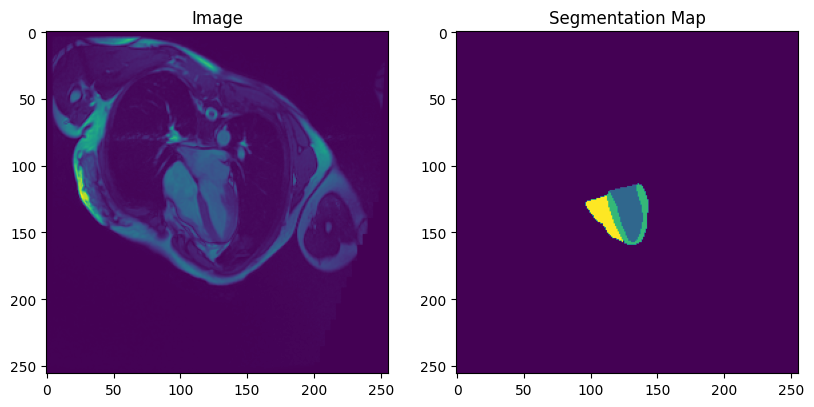

In [ ]:
plot_images_by_path('MnM2/','training','LA','ES','001')

# Slect and load the data

In [ ]:
def select_data(env,datatype_anotation):
  file_input = f'MnM2/{env}/*/*{datatype_anotation}*'
  return sorted(glob.glob(file_input))

def load_data(filenames):
  image_raw = []
  masks_raw = []

  for file_name in tqdm(filenames):
    if 'gt' not in file_name:
      img = nb.load(file_name).get_fdata()
      image_raw.append(img)
    else:
      mask = nb.load(file_name).get_fdata()
      masks_raw.append(mask)

  return image_raw, masks_raw

## Training

In [ ]:
training_file_names_LA = select_data('training', '_LA_ES') + select_data('training', '_LA_ED')
training_file_names_SA = select_data('training', '_SA_ES') + select_data('training', '_SA_ED')

# training_images_LA_raw, training_masks_LA_raw = load_data(training_file_names_LA)
training_images_SA_raw, training_masks_SA_raw = load_data(training_file_names_SA)

100%|██████████| 640/640 [03:22<00:00,  3.16it/s]


## Testing

In [ ]:
testing_file_names_LA = select_data('testing', '_LA_ES') + select_data('testing', '_LA_ED')
testing_file_names_SA = select_data('testing', '_SA_ES') + select_data('testing', '_SA_ED')

# testing_images_LA_raw, testing_masks_LA_raw = load_data(testing_file_names_LA)
testing_images_SA_raw, testing_masks_SA_raw = load_data(testing_file_names_SA)

100%|██████████| 640/640 [03:13<00:00,  3.31it/s]


## Validation

In [ ]:
validation_file_names_LA = select_data('validation', '_LA_ES') + select_data('validation', '_LA_ED')
validation_file_names_SA = select_data('validation', '_SA_ES') + select_data('validation', '_SA_ED')

# validation_images_LA_raw, validation_masks_LA_raw = load_data(validation_file_names_LA)
validation_images_SA_raw, validation_masks_SA_raw = load_data(validation_file_names_SA)

100%|██████████| 160/160 [00:51<00:00,  3.11it/s]


# Formating

- resize for LA
- resize and padding for SA

## Format SA

### Analyze the depth of images in the dataset

In [ ]:
def analyze_depth(SA_images_raw, SA_masks_raw):
  SA_depth_count = {}  # Dictionary to store the depth and count of images and masks

  for img in SA_images_raw:
      depth = img.shape[-1]  # Get the depth of the image
      # Update the SA_depth_count dictionary
      if depth in SA_depth_count:
          SA_depth_count[depth] += 1
      else:
          SA_depth_count[depth] = 1

  for mask in SA_masks_raw:
      depth = mask.shape[-1]  # Get the depth of the mask
      # Update the SA_depth_count dictionary
      if depth in SA_depth_count:
          SA_depth_count[depth] += 1
      else:
          SA_depth_count[depth] = 1

  # Print the depths and their corresponding counts
  print("Depth in the dataset and the count of images/masks for each:")
  for depth, count in SA_depth_count.items():
      print(f"Depth: {depth}, Count of Images/Masks: {count}")


### Add zero padding for the images with the shorter depth

In [ ]:
all_images = (training_images_SA_raw + testing_images_SA_raw + validation_images_SA_raw)
all_masks = (training_masks_SA_raw + testing_masks_SA_raw + validation_masks_SA_raw)

In [ ]:
analyze_depth(all_images,all_masks)

Depth in the dataset and the count of images/masks for each:
Depth: 12, Count of Images/Masks: 400
Depth: 10, Count of Images/Masks: 428
Depth: 11, Count of Images/Masks: 240
Depth: 14, Count of Images/Masks: 76
Depth: 9, Count of Images/Masks: 72
Depth: 8, Count of Images/Masks: 20
Depth: 16, Count of Images/Masks: 12
Depth: 13, Count of Images/Masks: 136
Depth: 6, Count of Images/Masks: 12
Depth: 15, Count of Images/Masks: 20
Depth: 7, Count of Images/Masks: 12
Depth: 17, Count of Images/Masks: 8
Depth: 28, Count of Images/Masks: 4


In [ ]:
def zero_padding(SA_images_raw, SA_masks_raw, depth):
  SA_images = []
  SA_masks = []

  for img, msk in zip(SA_images_raw, SA_masks_raw):
      depth_diff = depth - img.shape[2]  # Calculate the depth difference

      # If depth is smaller, add zero padding to the depth dimension
      if depth_diff > 0:
          pad_width = ((0, 0), (0, 0), (0, depth_diff))  # (height, width, depth)
          img = np.pad(img, pad_width, mode='constant', constant_values=0)
          msk = np.pad(msk, pad_width, mode='constant', constant_values=0)

      # Resize to 240x240x18
      bottle_img = resize(img, (240, 240, depth))
      # bottle_mask = resize(msk, (240, 240, depth))
      bottle_mask = cv2.resize(msk, (240, 240), interpolation=cv2.INTER_NEAREST)

      del img
      del msk

      SA_images.append(bottle_img)
      SA_masks.append(bottle_mask)

  return SA_images, SA_masks

In [ ]:
training_images_SA, training_masks_SA = zero_padding(training_images_SA_raw, training_masks_SA_raw, 32)
testing_images_SA, testing_masks_SA = zero_padding(testing_images_SA_raw, testing_masks_SA_raw, 32)
validation_images_SA, validation_masks_SA = zero_padding(validation_images_SA_raw, validation_masks_SA_raw, 32)

img  (240, 240, 32)
mask  (240, 240, 32)
mask min  0.0
mask max  3.0
mask unique values  [0. 1. 2. 3.]


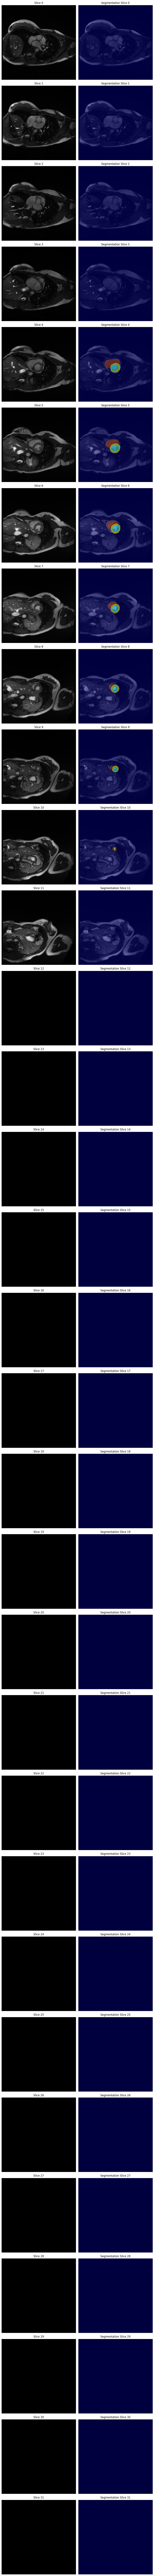

In [ ]:
plot_3d_images(training_images_SA[0],training_masks_SA[0])

## Format LA

In [ ]:
from skimage.transform import resize

def resize_images(LA_images_raw, LA_masks_raw):
  LA_images = []
  LA_masks = []

  for img, msk in zip(LA_images_raw, LA_masks_raw):
      # Resize to 200x200
      bottle_img = resize(img, (240, 240))
      # bottle_mask = resize(msk, (240, 240))
      bottle_mask = cv2.resize(msk, (240, 240), interpolation=cv2.INTER_NEAREST) #using interpolation to make sure we don't losse information while averaging the class values while resizing

      LA_images.append(bottle_img)
      LA_masks.append(bottle_mask)

  return LA_images, LA_masks;

In [ ]:
training_images_LA, training_masks_LA = resize_images(training_images_LA_raw, training_masks_LA_raw)
testing_images_LA, testing_masks_LA = resize_images(testing_images_LA_raw, testing_masks_LA_raw)
validation_images_LA, validation_masks_LA = resize_images(validation_images_LA_raw, validation_masks_LA_raw)

(240, 240, 1) (240, 240) 0.0 3.0 [0. 1. 2. 3.]


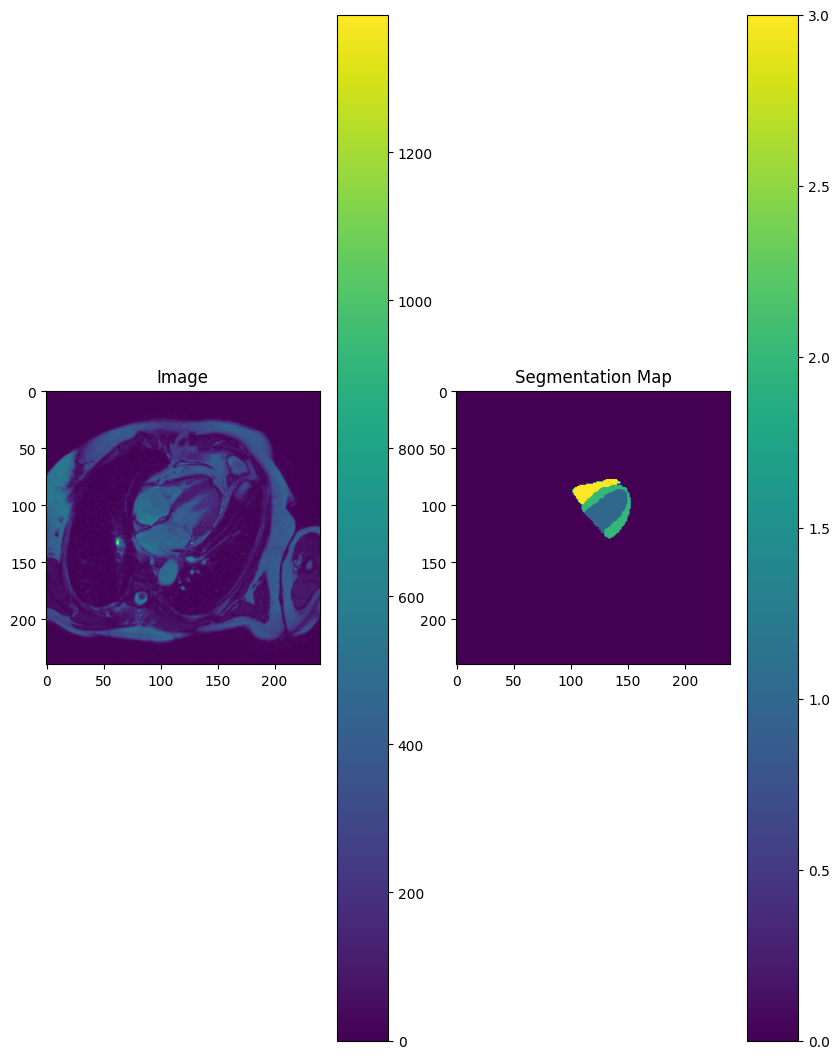

In [ ]:
plot_images_after_cleaning(validation_images_LA[0], validation_masks_LA[0])

# Persist the data

## Persist SA

In [ ]:
!mkdir 'MnM2/training'
!mkdir 'MnM2/testing'
!mkdir 'MnM2/validation'

In [ ]:
!mkdir 'MnM2/training/SA'
!mkdir 'MnM2/testing/SA'
!mkdir 'MnM2/validation/SA'

mkdir: cannot create directory ‘MnM2/training/SA’: File exists
mkdir: cannot create directory ‘MnM2/testing/SA’: File exists
mkdir: cannot create directory ‘MnM2/validation/SA’: File exists


In [ ]:
np.save('MnM2/training/SA/images.npy', training_images_SA)
np.save('MnM2/training/SA/masks.npy', training_masks_SA)

In [ ]:
np.save('MnM2/testing/SA/images.npy', testing_images_SA)
np.save('MnM2/testing/SA/masks.npy', testing_masks_SA)

In [ ]:
np.save('MnM2/validation/SA/images.npy', validation_images_SA)
np.save('MnM2/validation/SA/masks.npy', validation_masks_SA)

## Persist LA

In [ ]:
!mkdir 'MnM2/training/LA'
!mkdir 'MnM2/testing/LA'
!mkdir 'MnM2/validation/LA'

mkdir: cannot create directory ‘MnM2/training/LA’: File exists
mkdir: cannot create directory ‘MnM2/testing/LA’: File exists
mkdir: cannot create directory ‘MnM2/validation/LA’: File exists


In [ ]:
np.save('MnM2/training/LA/images.npy', training_images_LA)
np.save('MnM2/training/LA/masks.npy', training_masks_LA)

In [ ]:
np.save('MnM2/testing/LA/images.npy', testing_images_LA)
np.save('MnM2/testing/LA/masks.npy', testing_masks_LA)

In [ ]:
np.save('MnM2/validation/LA/images.npy', validation_images_LA)
np.save('MnM2/validation/LA/masks.npy', validation_masks_LA)

## Visualize after split for verification

### SA sample

img  (240, 240, 32)
mask  (240, 240, 32)
mask min  0.0
mask max  3.0
mask unique values  [0. 1. 2. 3.]


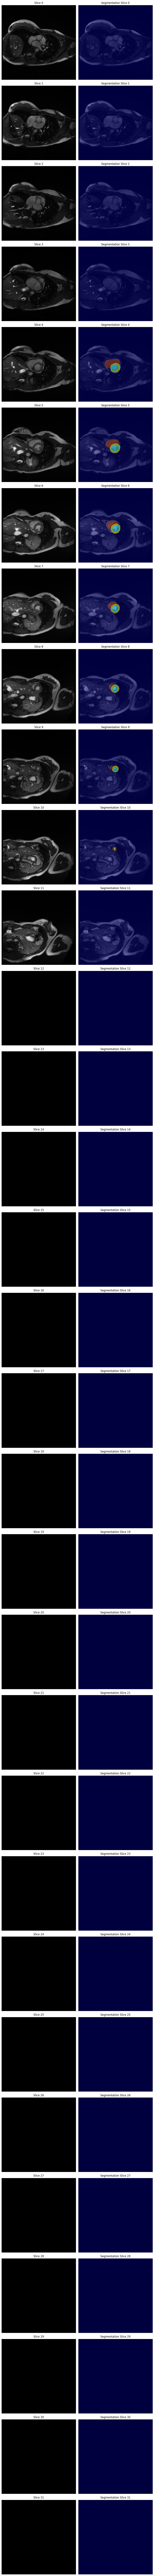

In [ ]:
plot_3d_images(training_images_SA[0],training_masks_SA[0])

### LA sample

img  (240, 240, 1)
mask  (240, 240)


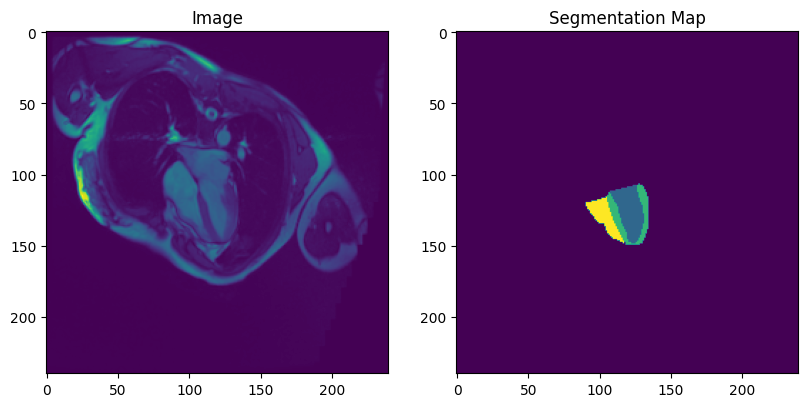

In [ ]:
plot_images(training_images_LA[0],training_masks_LA[0])